# Kaggle InClass RnD-42. Предсказание повтора произошедшего события.

Необходимо решить задачу бинарной классификации с анонимизированными данными. Единственное, что известно про данные:
- Каждое наблюдение имеет собственный уникальный IDэ.
- Каждый ряд в таблице представляет собой событие, произошедшее во время "DT". Задача предсказать, произойдёт ли это событие ещё раз в тот же самый день (метка класса 1) или нет (метка класса 0).
- Столбцы с префиксом "N_" содержат числовые переменные, с префиксом "C_" — категориальные.

Качество решения оценивается по метрике AUC ROC.

In [ ]:
# Загрузим данные с kaggle
!kaggle competitions download -c rnd-42-welcome
!unzip '*.zip'

 13%|████▊                                 | 1.00M/7.99M [00:00<00:00, 9.96MB/s]
100%|██████████████████████████████████████| 7.99M/7.99M [00:00<00:00, 46.6MB/s]
Archive:  rnd-42-welcome.zip
  inflating: r42_welcome_test/r42_welcome_test.csv  
  inflating: r42_welcome_test_sample.csv  
  inflating: r42_welcome_train/r42_welcome_train.csv  
  inflating: r42_welcome_train_res.csv  


## Смотрим на данные

In [ ]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
from time import time
from hyperopt import hp, tpe, pyll, space_eval
from hyperopt.fmin import fmin
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv('r42_welcome_train.csv', sep=';', parse_dates=['DT'], index_col='ID')
train_data.head()

,DT,C_1,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,...,N_46,N_47,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_60,N_61,N_62,N_63,N_64,N_65,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,C_2,C_3,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27253,2019-02-24 13:13:52,6,2.4,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0000,0.00,0.0,0.0000,0.0714,1.0,0.0476,1.00,0.0333,1.0,0.0167,0.0166,1.0,0.0111,0.0056,1.0000,0.5000,1.0,0.5000,0.3333,...,1.0,0.0667,0.0526,0.0141,1.0,0.0526,-1,-410,-0.5,0.0,-0.1667,0.0,7,120.0000,60.0000,120.0000,60.0000,0.0000,0.0400,0.0400,0.0400,0.0000,0.9600,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.5000,1,NaN,1.0000,2,780.0,1,0.0000,1.0000,0.7741,0.7383
173769,2019-12-14 07:22:57,3,0.4,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.00,0.0000,0.0,0.0167,-0.0167,1.0,0.0556,-0.0389,1.6667,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.1667,-0.1667,2.0,0.0833,0,0,0.0,0.0,0.0000,0.0,57,3.0000,-54.0000,3.0000,-54.0000,0.0000,0.0588,0.0588,0.0588,0.0000,0.9412,0.4000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6000,1,1.0,1.0000,1,270.0,1,0.0000,1.0000,-0.5309,-0.2683
138042,2019-10-04 14:42:17,1,4.0,0.3,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,0.5,0.3333,0.25,0.2,0.1667,0.2143,1.5,0.2381,1.25,0.2333,1.4,0.2500,-0.0167,1.5,0.2556,-0.0056,1.4375,1.0000,2.0,0.5000,0.6667,...,2.0,0.2500,0.3333,0.1667,2.0,0.1667,1,270,-1.0,-300.0,-0.5000,115.0,2,1.0000,-1.0000,1.0000,-1.0000,0.0000,0.2778,0.2778,0.3333,0.0556,0.6667,0.2963,0.0556,0.0000,0.0370,0.0556,0.0556,0.5000,1,1.0,1.0000,2,550.0,1,0.0000,1.0000,0.1805,0.1026
49748,2019-04-10 11:32:47,0,0.4,0.6,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,1.0,0.6667,0.50,0.4,0.3333,0.1429,2.0,0.0952,2.00,0.0667,2.0,0.0500,0.0167,1.5,0.0333,0.0167,1.5000,0.3333,2.0,0.1667,0.2222,...,1.5,0.0833,0.0811,0.0439,1.5,0.0541,2,780,2.0,780.0,1.8333,780.0,1,40.0000,39.0000,100.0000,99.0000,0.0000,0.0213,0.0213,0.0426,0.0213,0.9574,0.0000,0.3333,0.0000,0.0000,0.0000,0.0000,0.6667,1,2.0,0.6667,1,330.0,5,0.0000,1.0000,-0.1871,0.3283
57182,2019-04-25 13:57:30,0,0.0,0.0,0,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1.0,1.0000,0.75,0.6,0.6667,0.6429,1.0,0.5714,1.00,0.6333,1.0,0.5667,0.0666,1.0,0.5444,0.0223,1.0000,1.0000,1.0,1.0000,0.8889,...,1.0,0.8800,0.8108,0.0692,1.0,0.8108,0,0,0.5,0.0,-0.1667,0.0,1,1.0833,0.0833,1.3333,0.3333,0.0426,0.7660,0.7660,0.8298,0.0638,0.1277,0.0435,0.2246,0.2174,0.1812,0.1594,0.0217,0.1522,1,NaN,0.9512,2,0.0,1,0.0488,0.1144,0.1169,0.3608


In [ ]:
test_data = pd.read_csv('r42_welcome_test.csv', sep=';', parse_dates=['DT'], index_col='ID')
test_data.head()

,DT,C_1,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,...,N_46,N_47,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_60,N_61,N_62,N_63,N_64,N_65,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,C_2,C_3,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48746,2019-04-08 19:54:29,4,0.5,0.4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.25,0.4,0.3333,0.2857,1.0000,0.2857,1.0000,0.2667,1.0000,0.2833,-0.0166,1.0000,0.2556,0.0277,1.0455,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0,0,0.0,0.0,0.0000,0.0000,1,120.0,60.0,120.00,60.00,0.0000,0.6875,0.6875,0.8125,0.1250,0.1875,0.1349,0.2619,0.0000,0.0317,0.1587,0.1032,0.3095,1,NaN,NaN,1,0.0,5,0.0,1.0000,1.8320,-0.1744
92555,2019-07-05 17:23:43,1,0.0,1.0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,2,0.5,0.6667,0.50,0.4,0.3333,0.2143,1.0000,0.2857,1.2000,0.3333,1.2500,0.2000,0.1333,1.2000,0.1778,0.0222,1.1429,0.0,0.0,0.0,0.0000,...,1.0000,0.1111,0.0769,0.0342,1.00,0.0769,1,450,0.0,225.0,0.3333,825.0000,1,4.0,3.0,4.00,3.00,0.0556,0.1667,0.1667,0.3333,0.1667,0.6111,0.2090,0.1642,0.0597,0.0299,0.0149,0.0448,0.4776,1,2.0,1.00,1,280.0,2,1.0,0.0410,0.8702,1.8024
26753,2019-02-23 23:46:02,3,0.0,2.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.00,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0,0,0.0,0.0,0.0000,0.0000,5,120.0,60.0,120.00,60.00,0.0000,0.0625,0.0625,0.0625,0.0000,0.9375,0.4762,0.0238,0.0476,0.0714,0.0238,0.0476,0.3095,1,NaN,NaN,2,660.0,1,0.0,1.0000,-0.6471,-0.5831
33515,2019-03-09 18:40:36,6,0.3,1.1,0,2,1,1,2,2,1,2,1,1,1,1,1,1,1,1.5,1.3333,1.50,1.6,1.5000,1.2857,1.2857,1.1905,1.1905,1.1333,1.1333,1.1333,0.0000,1.1333,1.2444,-0.1111,1.2444,1.0,1.0,1.0,1.0000,...,1.1111,1.0000,1.1500,-0.0389,1.15,1.0000,1,340,1.5,1670.0,1.5000,2319.1667,1,1.0,0.0,1.00,0.00,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4518,0.0000,0.4839,0.0596,0.0000,0.0023,0.0023,2,NaN,1.00,3,1025.0,2,1.0,0.0656,1.3223,1.3605
94357,2019-07-08 10:48:52,4,2.0,0.4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0000,0.00,0.0,0.0000,0.2143,1.5000,0.2381,1.6667,0.2333,1.4000,0.2333,0.0000,1.4000,0.1778,0.0555,1.3333,0.5,1.0,0.5,0.3333,...,1.0000,0.2222,0.2308,-0.0086,1.00,0.2308,-2,-660,-2.5,-495.0,-2.0000,-26.6667,10,3.5,-6.5,4.25,-5.75,0.0000,0.0556,0.0556,0.2222,0.1667,0.7778,0.1600,0.0800,0.0800,0.0000,0.0400,0.0400,0.6000,1,1.0,0.75,1,330.0,1,0.0,1.0000,0.8697,-0.2539


In [ ]:
labels = pd.read_csv('r42_welcome_train_res.csv', sep=';', index_col='ID')
labels.head()

,Y
ID,
27253,0
173769,0
138042,0
49748,0
57182,0


In [ ]:
# Посмотрим на баланс классов
labels.value_counts(normalize=True)

Y
0    0.703417
1    0.296583
dtype: float64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 27253 to 36975
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DT      60000 non-null  datetime64[ns]
 1   C_1     60000 non-null  int64         
 2   N_1     60000 non-null  float64       
 3   N_2     60000 non-null  float64       
 4   N_3     60000 non-null  int64         
 5   N_4     60000 non-null  int64         
 6   N_5     60000 non-null  int64         
 7   N_6     60000 non-null  int64         
 8   N_7     60000 non-null  int64         
 9   N_8     60000 non-null  int64         
 10  N_9     60000 non-null  int64         
 11  N_10    60000 non-null  int64         
 12  N_11    60000 non-null  int64         
 13  N_12    60000 non-null  int64         
 14  N_13    60000 non-null  int64         
 15  N_14    60000 non-null  int64         
 16  N_15    60000 non-null  int64         
 17  N_16    60000 non-null  int64         
 18  N_

In [ ]:
train_data.describe()

,C_1,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,N_39,...,N_46,N_47,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_60,N_61,N_62,N_63,N_64,N_65,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,C_2,C_3,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82
count,60000.000000,60000.000000,60000.000000,60000.0,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,35258.000000,47571.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,59821.000000,59646.000000
mean,2.248900,1.592330,1.591285,0.0,0.36315,0.326883,0.302950,0.305417,0.306067,0.333833,0.387117,0.035033,0.371783,0.308883,0.355117,0.302583,0.356250,0.295567,0.345017,0.330991,0.324600,0.320893,0.323053,0.320522,0.953536,0.312811,1.019068,0.306009,1.067953,0.290906,0.015103,1.138472,0.281416,0.009490,1.165021,0.386889,0.635342,0.271477,0.380551,0.723674,...,0.913804,0.253040,0.345499,0.012129,0.975335,0.245427,-0.238917,-50.978583,-0.199525,191.259342,-0.102890,347.351271,7.869200,29.826464,13.439464,30.062062,13.675062,0.036973,0.169554,0.169554,0.341829,0.172275,0.621198,0.132552,0.064848,0.096062,0.081442,0.034487,0.052207,0.524418,1.066833,1.802201,0.876456,1.379067,342.090917,3.345317,0.261702,0.662121,0.692161,0.447065
std,2.291405,3.030422,3.045505,0.0,0.81073,0.778272,0.755897,0.767364,0.755579,0.787675,0.822031,0.753779,0.802104,0.749700,0.779264,0.757872,0.781247,0.723843,0.695357,0.635226,0.604724,0.582284,0.576687,0.551703,0.778338,0.535569,0.739646,0.520208,0.701901,0.465230,0.139039,0.635287,0.427073,0.094923,0.603410,0.688337,0.856935,0.349382,0.648467,0.849540,...,0.788610,0.279226,0.515599,0.128966,0.754115,0.268147,2.160227,692.216803,1.989833,818.027291,1.940026,1241.529316,23.007138,48.943509,28.568010,48.934007,28.578306,0.112867,0.231432,0.231432,0.280375,0.184414,0.303236,0.158975,0.080593,0.129139,0.111815,0.047783,0.070884,0.285831,0.435358,0.691738,0.189739,0.755922,352.802258,2.776311,0.369364,0.392529,0.816113,0.752430
min,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.783400,0.000000,0.000000,-1.333300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.815500,0.000000,0.000000,-56.000000,-21200.000000,-56.000000,-6500.000000,-39.166700,-1298.333300,1.000000,1.000000,-113.000000,1.000000,-113.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.142900,1.000000,0.000000,1.000000,0.000000,-0.051400,-0.988900,-0.995300
25%,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047600,1.000000,0.033300,1.000000,0.050000,-0.033300,1.000000,0.044400,-0.016600,1.000000,0.000000,0.000000,0.

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 48746 to 167733
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DT      15000 non-null  datetime64[ns]
 1   C_1     15000 non-null  int64         
 2   N_1     15000 non-null  float64       
 3   N_2     15000 non-null  float64       
 4   N_3     15000 non-null  int64         
 5   N_4     15000 non-null  int64         
 6   N_5     15000 non-null  int64         
 7   N_6     15000 non-null  int64         
 8   N_7     15000 non-null  int64         
 9   N_8     15000 non-null  int64         
 10  N_9     15000 non-null  int64         
 11  N_10    15000 non-null  int64         
 12  N_11    15000 non-null  int64         
 13  N_12    15000 non-null  int64         
 14  N_13    15000 non-null  int64         
 15  N_14    15000 non-null  int64         
 16  N_15    15000 non-null  int64         
 17  N_16    15000 non-null  int64         
 18  N

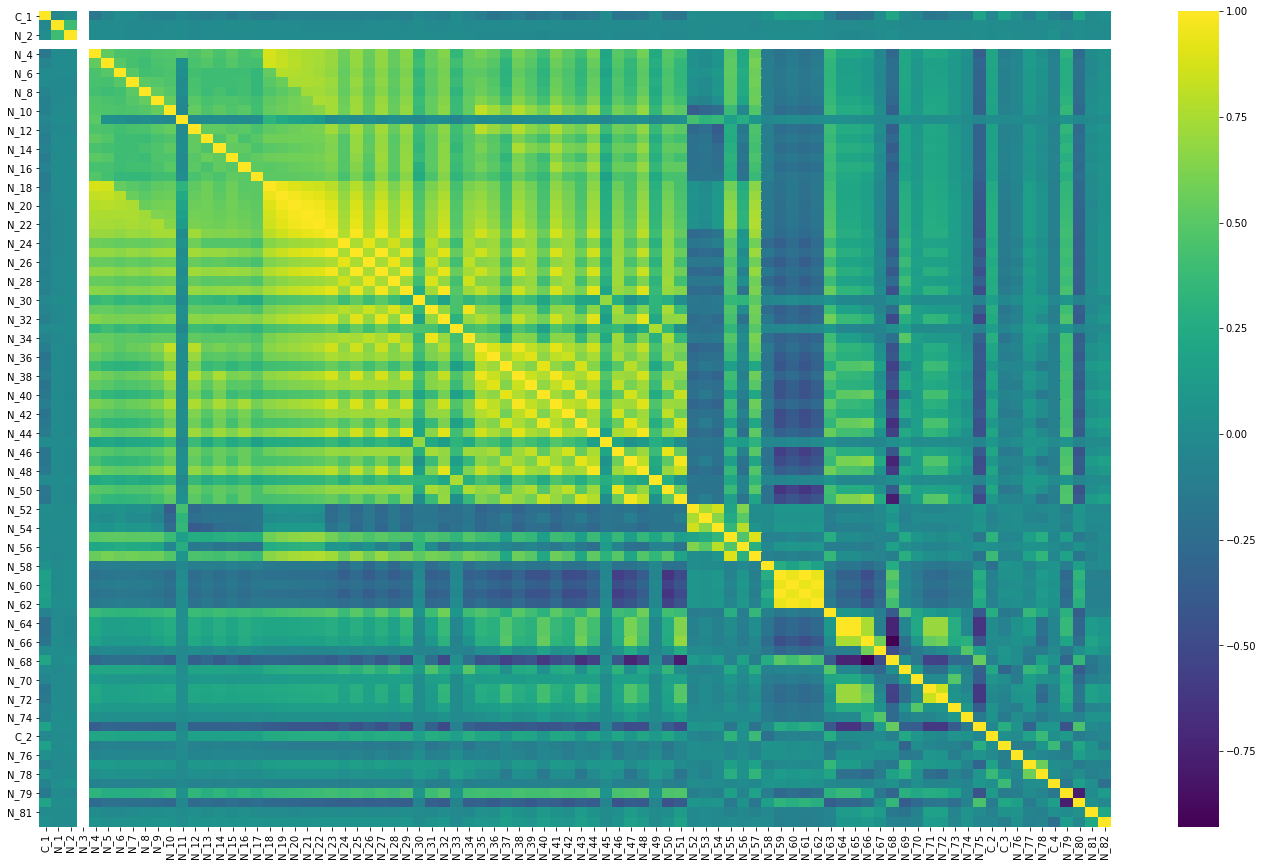

In [ ]:
# Посмотрим на корреляции признаков
plt.figure(figsize=(24,15))
sns.heatmap(train_data.corr(), cmap='viridis', cbar=True);

Какие выводы можно сделать из полученной информации:
- Данные имеют 87 столбцов, из которых 4 столбца с категориальными значениями.
- Как в тренировочном, так и в тестовом множестве содержится 4 столбца с пропущенными значениями. 
- Можно заметить, что как минимум один столбец ("N_3") состоит полностью из нулевых значений.
- Некоторые признаки довольно сильно коррелируют между собой.
- Имеется небольшой дисбаланс классов.

## Предобработка данных и baseline модель.
Для построения первой модели выбросим информацию о дате и столбцы, обладающие очень низкой дисперсией (столбцы наподобие N_3). Пропуски для числовых значений заполним средним значением, а для категориальных заполним новой категорией -1.

In [ ]:
def cat_num_divide(df_columns):
    '''
    Делит столбцы данных на числовые и категориальные
    '''
    cat_cols, num_cols = [], []
    for col in df_columns:
        if col.startswith('C'):
            cat_cols.append(df_columns.get_loc(col))
        else:
            num_cols.append(df_columns.get_loc(col))
    return cat_cols, num_cols

In [ ]:
def get_pipeline(model, num_cols, cat_cols, num_strat='mean'):
    '''
    Возвращает pipeline с предобработанными данными и моделью model.

    Пропущенные значения в числовых столбцах заполняются способом num_strat,
    затем данные масштабируются с помощью StandardScaler.
    
    Пропущенные значения в категориальных столбцах заполняются константой -1,
    затем данные кодируются с помощью OneHotEncoder.
    '''
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_strat)),
        ('scaler', StandardScaler())])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)], n_jobs=-1)

    pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clf', model)])
    
    return pipe

In [ ]:
def get_cv_and_holdout_scores(model, X, y, X_holdout, y_holdout, cv=5, verbose=1):
    '''
    Возвращает качество модели на каждом фолде кросс-валидации,
    среднее качество модели на кросс-валидации, а также качество модели на отложенной выборке.
    Метрика AUC ROC.
    '''
    start_time = time()
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    mean_cv = cv_scores.mean()

    model.fit(X, y)
    probs = model.predict_proba(X_holdout)[:, 1]
    holdout_score = roc_auc_score(y_holdout, probs)

    if verbose:
        print(f'CV scores: {cv_scores}')
        print(f'Mean CV score: {mean_cv:.4f}')
        print(f'Score on holdout set: {holdout_score:.4f}')
        print(f'Elapsed Time: {(time() - start_time):.2f} s')
    return cv_scores, mean_cv, holdout_score

In [ ]:
def create_submission(indexes, probs, filename='submission.csv'):
    '''
    Создаёт файл для отправки на Kaggle.
    '''
    df = pd.DataFrame(probs, index=indexes, columns=['Y'])
    subm = df.to_csv(filename)

In [ ]:
cols_to_drop = ['DT'] + [col for col in train_data.columns[1:] if train_data[col].std() <= 0.001]
print(f'Столбцы для удаления: {cols_to_drop}')

Столбцы для удаления: ['DT', 'N_3']


In [ ]:
# Создадим новый датасет без выбранных выше столбцов
train_data2 = train_data.drop(cols_to_drop, axis=1)
test_data2 = test_data.drop(cols_to_drop, axis=1)
cat_cols, num_cols = cat_num_divide(train_data2.columns)

In [ ]:
# Сделаем отложенную выборку, чтобы проверять на ней качество моделей
X, X_holdout, y, y_holdout = train_test_split(train_data2, labels, test_size=15000,
                                              stratify=labels, random_state=42)

In [ ]:
# Зададим способ кросс-валидации
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

В качестве первой модели выберем простую логистическую регрессию без настройки гиперпараметров.

In [ ]:
logit = LogisticRegression(random_state=42, n_jobs=-1)
pipe = get_pipeline(logit, num_cols, cat_cols)

In [ ]:
cv_scores, mean_cv, holdout_score = get_cv_and_holdout_scores(pipe, X, y, X_holdout, y_holdout, cv=skf)

CV scores: [0.88763571 0.89072115 0.89006421]
Mean CV score: 0.8895
Score on holdout set: 0.8922
Elapsed Time: 24.28 s


Проверим, как данная модель показывает себя в соревновании.

In [ ]:
pipe.fit(train_data2, labels);

In [ ]:
test_probs = pipe.predict_proba(test_data2)[:, 1]
create_submission(test_data2.index, test_probs)

С помощью этой модели достигнут результат 0.88480 в таблице рейтинга.

## Выбор модели
Посмотрим, как справятся с этими данными другие классификаторы. Проверим kNN, Naive Bayes Classificator, Decision Tree, Random Forest и классификатор из библиотеки XGBoost. (SVM проверять не будем, так как он не имеет метода `predict_proba`).

In [ ]:
models = [('kNN', KNeighborsClassifier()),
          ('Bayes', GaussianNB()),
          ('Decision Tree', DecisionTreeClassifier(random_state=42)),
          ('Random Forest', RandomForestClassifier(n_jobs=-1, random_state=42)),
          ('XGB', XGBClassifier(random_state=42, n_jobs=-1)),
          ]

In [ ]:
for name, model in models:
    start_time = time()
    pipe = get_pipeline(model, num_cols, cat_cols)
    print(name)
    get_cv_and_holdout_scores(pipe, X, y, X_holdout, y_holdout, cv=skf)
    print()

kNN
CV scores: [0.84290798 0.84510993 0.8423232 ]
Mean CV score: 0.8434
Score on holdout set: 0.8432
Elapsed Time: 333.30 s
Fitting time: 333.30 s

Bayes
CV scores: [0.79423087 0.79706101 0.79760832]
Mean CV score: 0.7963
Score on holdout set: 0.7973
Elapsed Time: 2.28 s
Fitting time: 2.28 s

Decision Tree
CV scores: [0.7295683  0.73157741 0.72991375]
Mean CV score: 0.7304
Score on holdout set: 0.7356
Elapsed Time: 8.87 s
Fitting time: 8.87 s

Random Forest
CV scores: [0.89403693 0.90022366 0.89758207]
Mean CV score: 0.8973
Score on holdout set: 0.8996
Elapsed Time: 36.21 s
Fitting time: 36.21 s

XGB
CV scores: [0.8975461  0.90430672 0.90212211]
Mean CV score: 0.9013
Score on holdout set: 0.9032
Elapsed Time: 24.50 s
Fitting time: 24.50 s



## Остановимся на XGBClassifier
Лучшее качество показал XGBClassifier, поэтому дальше будем использовать его. Для начала проверим, как влияет на качество модели способ заполнения пропусков в числовых признаках.

In [ ]:
strategies = ['mean', 'median', 'most_frequent', 'constant']

In [ ]:
xgbc = XGBClassifier(random_state=42, n_jobs=-1)

In [ ]:
for strat in strategies:
    pipe = get_pipeline(xgbc, num_cols, cat_cols, num_strat=strat)
    print(strat)
    get_cv_and_holdout_scores(pipe, X, y, X_holdout, y_holdout, cv=skf)
    print()

mean
CV scores: [0.8975461  0.90430672 0.90212211]
Mean CV score: 0.9013
Score on holdout set: 0.9032
Elapsed Time: 24.42 s

median
CV scores: [0.89763891 0.90447058 0.90212211]
Mean CV score: 0.9014
Score on holdout set: 0.9033
Elapsed Time: 25.09 s

most_frequent
CV scores: [0.89790009 0.90428836 0.90218122]
Mean CV score: 0.9015
Score on holdout set: 0.9032
Elapsed Time: 24.28 s

constant
CV scores: [0.89807669 0.90407542 0.90256294]
Mean CV score: 0.9016
Score on holdout set: 0.9031
Elapsed Time: 23.78 s



Дальше будем использовать стратегию `'median'`, так как она показала результаты лучше на двух первых фолдах кросс-валидации и такие же на третьем (в отличие от остальных, где результаты не хуже только на 2 фолдах из 3). При этом показала лучшие результаты на отложенной выборке.

## Подбор гиперапарметров
Проведём подбор гиперпараметров классификатора с помощью библиотеки `hyperopt`. 

In [ ]:
def hyperopt_xgb_score(params):
    '''
    Вспомогательная функция для hyperopt.
    Принимает распределения параметров для поиска.
    Возвращает метрику, которую необходимо минимизировать.
    '''
    clf = XGBClassifier(random_state=42, **params)
    pipe = get_pipeline(clf, num_cols, cat_cols, num_strat='median')
    current_score = cross_val_score(pipe, X.values, y.values.ravel(), cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score

In [ ]:
# Определяем распределения параметров и выбираем лучшие
space_xgb2 = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'learning_rate': hp.quniform('learning_rate', 0.001, 0.1, 0.005),
            'max_depth': hp.choice('max_depth', np.arange(1, 15, dtype=int)),
            'reg_alpha': hp.quniform('reg_alpha', 1e-5, 1, 1e-5),
            'reg_lambda': hp.quniform('reg_lambda', 1e-5, 1, 1e-5),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'gpu_hist'
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, algo=tpe.suggest, max_evals=50)
print('best:')
print(space_eval(space_xgb2, best))

In [ ]:
space_eval(space_xgb2, best)

{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'gamma': 0.8,
 'learning_rate': 0.015,
 'max_depth': 7,
 'min_child_weight': 1.0,
 'n_estimators': 717,
 'objective': 'binary:logistic',
 'reg_alpha': 0.7155900000000001,
 'reg_lambda': 0.72104,
 'subsample': 0.8500000000000001,
 'tree_method': 'gpu_hist'}

Обучим классификатор с лучшими параметрами и отправим результат на Kaggle.

In [ ]:
best_params = {'booster': 'gbtree',
               'colsample_bytree': 0.5,
               'gamma': 0.8,
               'learning_rate': 0.015,
               'max_depth': 7,
               'min_child_weight': 1.0,
               'n_estimators': 717,
               'objective': 'binary:logistic',
               'reg_alpha': 0.7155900000000001,
               'reg_lambda': 0.72104,
               'subsample': 0.8500000000000001,
               'tree_method': 'gpu_hist'}

In [ ]:
best_xgbc = XGBClassifier(**best_params, random_state=42)
pipe = get_pipeline(best_xgbc, num_cols, cat_cols, num_strat='median')
cv_scores, mean_cv, holdout_score = get_cv_and_holdout_scores(pipe, X, y, X_holdout, y_holdout, cv=skf)

CV scores: [0.90166132 0.91023921 0.90738138]
Mean CV score: 0.9064
Score on holdout set: 0.9099
Elapsed Time: 28.75 s


In [ ]:
pipe.fit(train_data2, labels);

In [ ]:
test_probs = pipe.predict_proba(test_data2)[:, 1]
create_submission(test_data2.index, test_probs)

Результат на Kaggle: 0.90681

## Вернём дату
Попробуем улучшить результат с помощью данных о дате, которые мы раньше не рассматривали. Вернём информацию о месяце, дне и часе.

In [ ]:
def get_features_from_date(dates):
    '''
    Получает столбец дат и возвращает DataFrame с 3 признаками:
    месяц, день, час.
    '''
    names = ['month', 'day', 'hour']
    months = dates.apply(lambda x: x.month)
    days = dates.apply(lambda x: x.day)
    hours = dates.apply(lambda x: x.hour)
    df = pd.concat([months, days, hours], axis=1)
    df.columns = names
    return df

In [ ]:
train_data3 = pd.concat([get_features_from_date(train_data.DT), train_data2], axis=1)
test_data3 = pd.concat([get_features_from_date(test_data.DT), test_data2], axis=1)

In [ ]:
cat_cols, num_cols = cat_num_divide(train_data3.columns)
X, X_holdout, y, y_holdout = train_test_split(train_data3, labels, test_size=15000,
                                              stratify=labels, random_state=42)
pipe = get_pipeline(best_xgbc, num_cols, cat_cols)

In [ ]:
cv_scores, mean_cv, holdout_score = get_cv_and_holdout_scores(pipe, X, y, X_holdout, y_holdout, cv=skf)

CV scores: [0.90577642 0.91313502 0.91131594]
Mean CV score: 0.9101
Score on holdout set: 0.9127
Elapsed Time: 27.37 s


In [ ]:
pipe.fit(train_data3, labels);

In [ ]:
test_probs = pipe.predict_proba(test_data3)[:, 1]
create_submission(test_data3.index, test_probs)

Учёт даты в признаках позволяет достичь качества 0.91025 на тестовом множестве, что на данный момент является лучшим результатом соревнования.

## Пробуем нейронную сеть
В качестве тренировки с PyTorch попробуем потренировать нейронную сеть.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Создаём свой класс датасета
class MyDataset(Dataset):
    def __init__(self, train_data, labels, transformer=None):
        self.data = train_data
        self.y = labels
        
        if transformer:
            self.data = transformer.transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data[index]
        label = self.y[index]

        return row, label

In [ ]:
def split_train_data(X, y):
    '''
    Разбивает данные на 3 части: тренировочную, валидационную и отложенную.
    Соотношение 0.5 | 0.25 | 0.25
    '''
    X_train, X_rest, y_train, y_rest = train_test_split(X, y,
                                                        stratify=y, shuffle=True,
                                                        test_size=0.5, random_state=42)
    
    X_val, X_holdout, y_val, y_holdout = train_test_split(X_rest, y_rest,
                                                          stratify=y_rest, shuffle=True,
                                                          test_size=0.5, random_state=42)
    
    return X_train, X_val, X_holdout, y_train, y_val, y_holdout

In [ ]:
def prepare_X_train(X_train, return_transformer=True):
    '''
    Предобрабатывает тренировочные данные и возвращает трансформер
    для предобработки валидационных и тестовых данных.
    '''
    cat_cols, num_cols = cat_num_divide(X_train.columns)
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)], n_jobs=-1)
    
    preprocessor = preprocessor.fit(X_train)
    X_train_trans = preprocessor.transform(X_train)

    if return_transformer:
        return X_train_trans, preprocessor
    else:
        return X_train_trans

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler=None):
    '''
    Тренирует нейронную сеть и возвращает список оценок качества на треировке и на валидации.
    '''
    for epoch in range(num_epochs):
        accum_loss = 0
        y_true = np.array([])
        y_pred = np.array([])
        train_history = []
        val_history = []

        for i, (X, y) in enumerate(train_loader):
            model.train()
            X = X.type(torch.cuda.FloatTensor)
            y = y.type(torch.cuda.LongTensor)

            optimizer.zero_grad()
            predictions = model(X)
            loss = criterion(predictions, y)
            accum_loss += loss.item()
            loss.backward()
            optimizer.step()

            y_pred = np.append(y_pred, predictions[:, 1].detach().cpu().numpy())
            y_true = np.append(y_true, y.detach().cpu().numpy())

        avg_loss = accum_loss / i
        train_score = roc_auc_score(y_true, y_pred)
        val_score = eval_model(model, val_loader)

        train_history.append(train_score)
        val_history.append(val_score)

        if scheduler:
            scheduler.step(avg_loss)

        print(f'Epoch: {epoch+1}; Loss: {avg_loss:.4f}; Train score: {train_score:.4f}; Val score: {val_score:.4f}')

    return train_history, val_history

def eval_model(model, val_loader):
    '''
    Даёт оценку качества модели на валидационном множестве.
    '''
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])

    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            X = X.type(torch.cuda.FloatTensor)
            y = y.type(torch.cuda.LongTensor)

            predictions = model(X)
            y_pred = np.append(y_pred, predictions[:, 1].detach().cpu().numpy())
            y_true = np.append(y_true, y.detach().cpu().numpy())

        score = roc_auc_score(y_true, y_pred)

    return score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
X_train, X_val, X_holdout, y_train, y_val, y_holdout = split_train_data(train_data3, labels)
X_train_trans, transformer = prepare_X_train(X_train)
in_features = X_train_trans.shape[1]

In [ ]:
# Создаём загрузчики данных с заданным размером батча
batch_size = 128

train_dataset = MyDataset(X_train_trans, y_train.to_numpy().ravel())
val_dataset = MyDataset(X_val.to_numpy(), y_val.to_numpy().ravel(), transformer=transformer)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.Softmax(1)
)
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=1)

In [ ]:
train_history, val_history = train_model(model, train_data_loader, val_data_loader, optimizer, criterion, 20, scheduler)

Epoch: 1; Loss: -0.7977; Train score: 0.8431; Val score: 0.8819
Epoch: 2; Loss: -0.8444; Train score: 0.8833; Val score: 0.8806
Epoch: 3; Loss: -0.8485; Train score: 0.8843; Val score: 0.8868
Epoch: 4; Loss: -0.8512; Train score: 0.8864; Val score: 0.8840
Epoch: 5; Loss: -0.8523; Train score: 0.8865; Val score: 0.8884
Epoch: 6; Loss: -0.8536; Train score: 0.8882; Val score: 0.8862
Epoch: 7; Loss: -0.8544; Train score: 0.8881; Val score: 0.8849
Epoch: 8; Loss: -0.8558; Train score: 0.8886; Val score: 0.8863
Epoch: 9; Loss: -0.8563; Train score: 0.8896; Val score: 0.8888
Epoch: 10; Loss: -0.8574; Train score: 0.8909; Val score: 0.8904
Epoch: 11; Loss: -0.8580; Train score: 0.8909; Val score: 0.8900
Epoch: 12; Loss: -0.8590; Train score: 0.8906; Val score: 0.8904
Epoch: 13; Loss: -0.8600; Train score: 0.8922; Val score: 0.8914
Epoch: 14; Loss: -0.8605; Train score: 0.8922; Val score: 0.8900
Epoch: 15; Loss: -0.8612; Train score: 0.8912; Val score: 0.8907
Epoch: 16; Loss: -0.8625; Train sc

Видно, что градиентный бустинг для данной задачи справляется лучше, чем нейронная сеть.